In [1]:
#импортируем библиотеки
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, accuracy_score
from gplearn.genetic import SymbolicClassifier

In [2]:
#!pip install gplearn

# Anomaly detection
**Задачи:**
- Исследовать данные, на наличие выбросов
- Сравнить целевые метрики ROC-AUC, Accuracy на 'сырых' данных и предобработанных

In [3]:
data = pd.read_csv('graduation_project_part2.csv')
display(data.head())
print(data.shape)

,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration_contract
0,52.55,Yes,Bank transfer (automatic),0.000,Two year,4472-LVYGI,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
1,20.25,No,Mailed check,0.000,Two year,3115-CZMZD,0,Male,0,No,Yes,Fiber optic,No,No,No,No,No,No,No,0
2,53.85,Yes,Mailed check,859.805,Month-to-month,3668-QPYBK,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,479
3,80.85,No,Mailed check,0.000,Two year,5709-LVOEQ,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4,70.70,Yes,Electronic check,657.510,Month-to-month,9237-HQITU,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,279


(7043, 20)


In [4]:
data.isna().sum()

MonthlyCharges       0
PaperlessBilling     0
PaymentMethod        0
TotalCharges         0
Type                 0
customerID           0
target               0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
duration_contract    0
dtype: int64

In [5]:
Y = data['target'].copy()
Y.value_counts()

0    5174
1    1869
Name: target, dtype: int64

### 3 сигмы
- Правило, утверждающее, что для любой случайной величины с конечной дисперсией вероятность того, что случайная величина отклонится от своего математического ожидания не менее, чем на три среднеквадратических отклонения

In [6]:
def sigma_outliers(data:pd.DataFrame, col:str, threshold=3, data_return=False):
    
    mean = data[col].mean()
    std = data[col].std()
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    #без any return 2col COL1, COL1 - False, False
    if data_return==False:
        anomalies = pd.concat([data[col]>upper_bound, data[col]<lower_bound], axis=1).any(1) 
        return anomalies, upper_bound, lower_bound    
    else:
        data = data[(data[col] < upper_bound) & (data[col] > lower_bound)]
        return data

In [7]:
def get_column_outliers(data, columns=None, function=sigma_outliers, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')#Series->False
                                                                                     #        False
    comparison_table = {}
    for column in columns_to_check: #col: fixed acidity, volatile acidity...
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True 
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']

    return comparison_table, outliers

In [8]:
def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*np.mean(outliers)))

In [9]:
features = data[['MonthlyCharges', 'TotalCharges', 'duration_contract']]
features.head()

,MonthlyCharges,TotalCharges,duration_contract
0,52.55,0.000,0
1,20.25,0.000,0
2,53.85,859.805,479
3,80.85,0.000,0
4,70.70,657.510,279


In [10]:
comparison_table, std_outliers = get_column_outliers(features)
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
MonthlyCharges,155.031834,-25.508449,0.0,0.000000
TotalCharges,3165.000381,-2173.963736,140.0,1.987789
duration_contract,548.983217,45.774131,30.0,0.425955


In [11]:
labeled_data = features.copy()
labeled_data['is_outlier'] = std_outliers

In [12]:
def make_pairplot(data, title: str):
    plot = sns.pairplot(data=data, hue='is_outlier', hue_order=[1, 0],
            markers=['o', 'v'],  palette='bright')
    plot.fig.suptitle(title, y=1.05)
    return plot

Total number of outliers: 170
Percentage of outliers:   2.41%


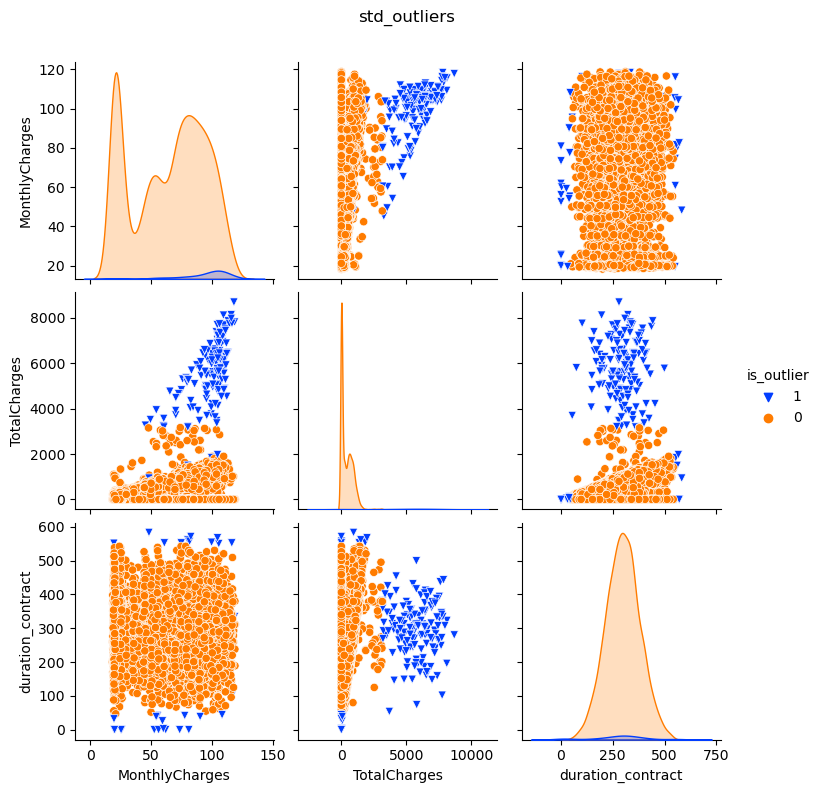

In [13]:
anomalies_report(std_outliers)
make_pairplot(labeled_data, 'std_outliers');

In [14]:
data['TotalCharges'].describe()

count    7043.000000
mean      495.518323
std       889.827353
min         0.000000
25%         0.000000
50%       258.036667
75%       732.167500
max      8684.800000
Name: TotalCharges, dtype: float64

In [15]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [16]:
def train_test(data):
    columns = ['MonthlyCharges', 'TotalCharges', 'duration_contract']
    
    X_train, X_test, y_train, y_test = train_test_split(data[columns], Y.iloc[data.index],  
                                                        test_size=0.25, random_state=111)
    
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [17]:
def make_predict(model, name, cv, df):
    X_train, X_test, y_train, y_test = train_test(df)
    
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean().round(3)
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean().round(3)
    return name, f'ROC-AUC: {score}, Accuracy: {acc}'

**Base predictions**

In [18]:
make_predict(LogisticRegression(), 'LR-base', 5, features)

('LR-base', 'ROC-AUC: 0.847, Accuracy: 0.772')

In [19]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-base', 5, features)

('DTC-base', 'ROC-AUC: 0.787, Accuracy: 0.731')

In [20]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-base', 5, features)

('SC-base', 'ROC-AUC: 0.851, Accuracy: 0.754')

**Вывод:**
- Получили предсказания на "сырых" данных
| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

In [21]:
#правило 3 сигм
data = sigma_outliers(features, 'TotalCharges', threshold=3, data_return=True)
data = sigma_outliers(data, 'MonthlyCharges', threshold=3, data_return=True)
data = sigma_outliers(data, 'duration_contract', threshold=3, data_return=True)

In [22]:
make_predict(LogisticRegression(), 'LR-3sigma', 5, data)

('LR-3sigma', 'ROC-AUC: 0.838, Accuracy: 0.769')

In [23]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-3sigma', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-3sigma', 'ROC-AUC: 0.787, Accuracy: 0.746')

In [24]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-3sigma', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-3sigma', 'ROC-AUC: 0.84, Accuracy: 0.768')

**Вывод:** 
- С помощью 3 сигм не удалось улучшить метрики



|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**3sigma**|**LR** |**0.838**|**0.769**|
|        |**DTC**|**0.787**|**0.746** |
|     |**SC** |**0.84** |**0.768**|
***

### IQR
- Статистический метод, используемый для измерения разброса набора данных.

In [25]:
def outlier_iqr(data, col, threshold=3, data_return=False):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    upper_bound = data[col].quantile(0.75) + (IQR * threshold)
    lower_bound = data[col].quantile(0.25) - (IQR * threshold)
    if data_return==False:
        anomalies = pd.concat([data[col]>upper_bound, data[col]<lower_bound], axis=1).any(axis=1)
        return anomalies, upper_bound, lower_bound
    else:
        data = data[(data[col] < upper_bound) & (data[col] > lower_bound)]
        return data

In [26]:
comparison_table, iqr_outliers = get_column_outliers(features, function=outlier_iqr)
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
MonthlyCharges,252.90,-127.5500,0.0,0.000000
TotalCharges,2928.67,-2196.5025,151.0,2.143973
duration_contract,678.00,-85.0000,0.0,0.000000


In [27]:
labeled_data = features.copy()
labeled_data['is_outlier'] = iqr_outliers

Total number of outliers: 151
Percentage of outliers:   2.14%


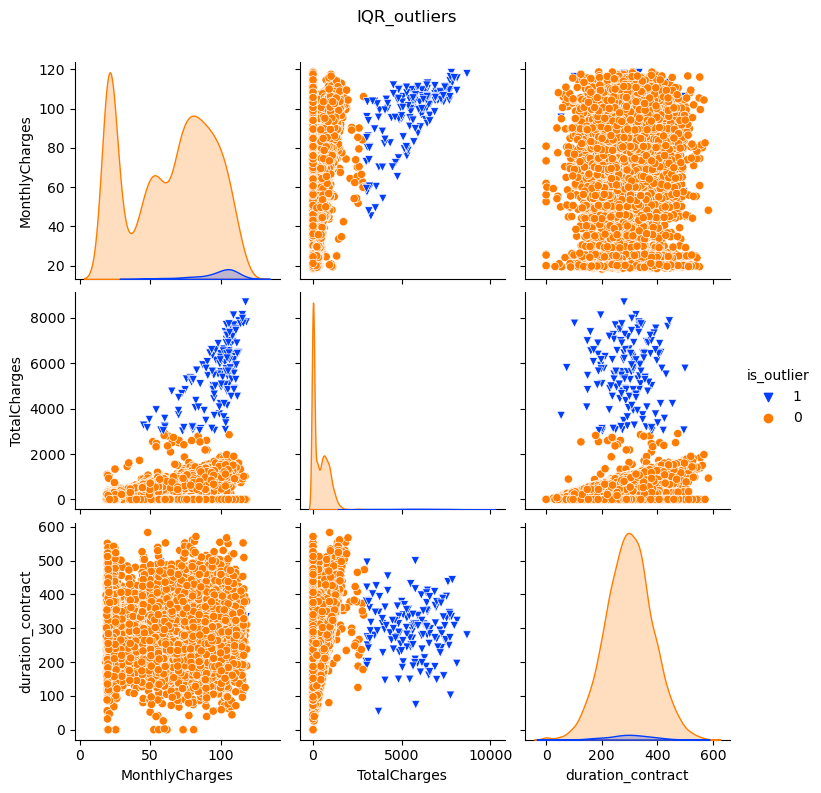

In [28]:
anomalies_report(iqr_outliers)
make_pairplot(labeled_data, 'IQR_outliers');

In [29]:
data = outlier_iqr(features, 'TotalCharges', threshold=3, data_return=True)
data = outlier_iqr(data, 'MonthlyCharges', threshold=3, data_return=True)
data = outlier_iqr(data, 'duration_contract', threshold=3, data_return=True)

In [30]:
make_predict(LogisticRegression(), 'LR-IQR', 5, data)

('LR-IQR', 'ROC-AUC: 0.832, Accuracy: 0.764')

In [31]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-IQR', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-IQR', 'ROC-AUC: 0.785, Accuracy: 0.748')

In [32]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-IQR', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-IQR', 'ROC-AUC: 0.837, Accuracy: 0.766')

**Вывод:**
- С помощью IQR не удалось улучшить метрику
|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|


***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**1.5*IQR**|**LR** |**0.832**|**0.764**|
|        |**DTC**|**0.785**|**0.748** |
|       |**SC** |**0.837** |**0.766**|

# Кластеризация
**Distance-based**
- Модель обнаружения выбросов на основе расстояния
- Метод подгонки вычисляет центр обучающих выборок и ,используя "метрику", получает расстояние от центра до обучающих выборок.
- Имея расстояния - мы вычисляем порог на основе процентиля.
    
- Метод прогнозирования использует порог и метрику, чтобы определить, является ли расстояние до выборки от центра слишком большим -> выброс.
- Параметры:
    - метрика: строка, по умолчанию - евклидова
        метрика, используемая для расчета расстояния (scipy.spatial.distance.cdist)
        
    - процентиль: плавающий в диапазоне [0, 100]
        гиперпараметр, устанавливающий порог для аномалий

In [33]:
class DistanceOutliers(BaseEstimator):

    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [34]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(data=scaler.fit_transform(features), columns=features.columns)
scaled_data.head()

,MonthlyCharges,TotalCharges,duration_contract
0,-0.327507,-0.352428,-2.733945
1,-0.921803,-0.352428,-2.733945
2,-0.303588,0.821900,1.660550
3,0.193192,-0.352428,-2.733945
4,0.006440,0.545604,-0.174312


In [35]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=90)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)

In [36]:
labeled_data = features.copy()
labeled_data['is_outlier'] = euclidian_outliers

Total number of outliers: 705
Percentage of outliers:   10.01%


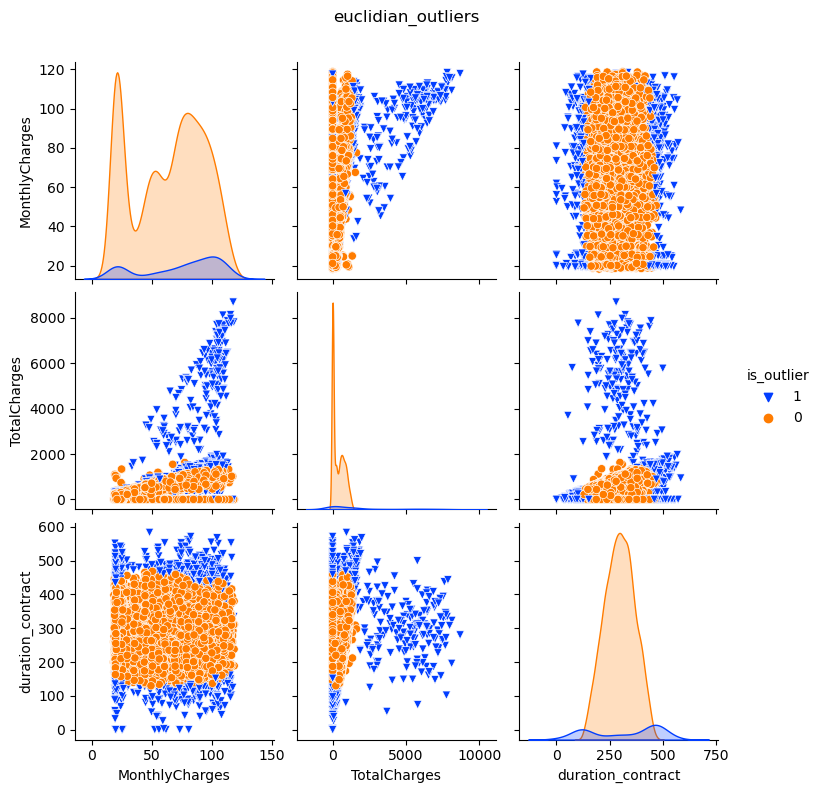

In [37]:
anomalies_report(euclidian_outliers)
make_pairplot(labeled_data, 'euclidian_outliers');

In [38]:
make_predict(LogisticRegression(), 'LR-euclidian', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-euclidian', 'ROC-AUC: 0.837, Accuracy: 0.773')

In [39]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-euclidian', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-euclidian', 'ROC-AUC: 0.781, Accuracy: 0.756')

In [40]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-euclidian', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-euclidian', 'ROC-AUC: 0.835, Accuracy: 0.771')

**Вывод:**
- Немного улучшили accuracy у двух моделей, но не сильно

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**Euclidian dist**|**LR** |**0.837**|**0.773**|
|        |**DTC**|**0.781**|**0.756** |
| ---    |**SC** |**0.835** |**0.771**|

In [41]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=90)
citiblock_model.fit(scaled_data)
cityblock_outliers = citiblock_model.predict(scaled_data)

In [42]:
labeled_data = features.copy()
labeled_data['is_outlier'] = cityblock_outliers

Total number of outliers: 705
Percentage of outliers:   10.01%


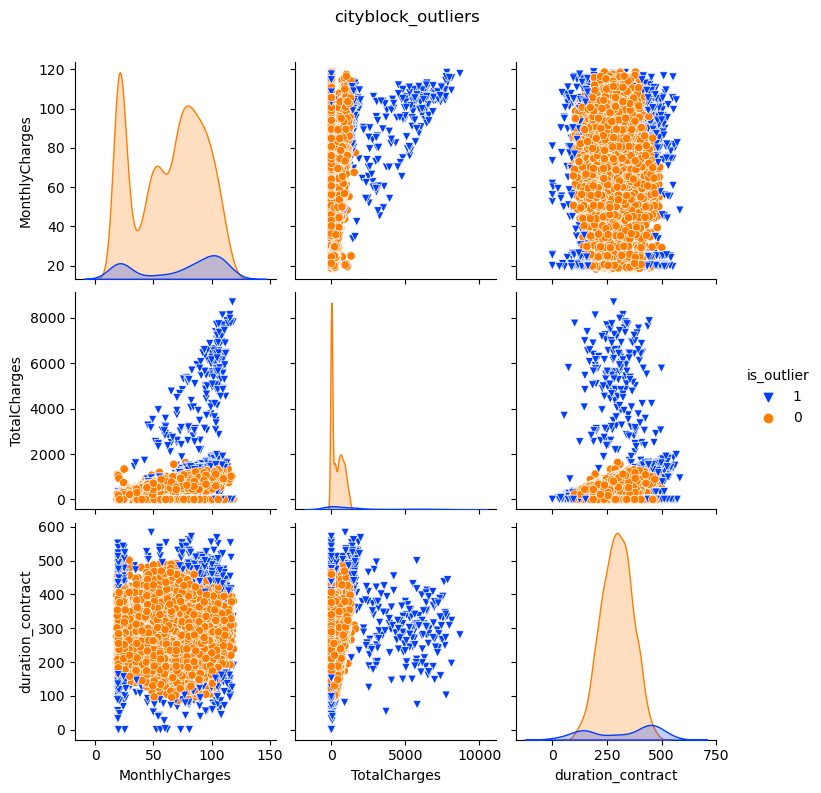

In [43]:
anomalies_report(cityblock_outliers)
make_pairplot(labeled_data, 'cityblock_outliers');

In [44]:
make_predict(LogisticRegression(), 'LR-cityblock', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-cityblock', 'ROC-AUC: 0.828, Accuracy: 0.764')

In [45]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-cityblock', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-cityblock', 'ROC-AUC: 0.781, Accuracy: 0.753')

In [46]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-cityblock', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-cityblock', 'ROC-AUC: 0.83, Accuracy: 0.767')

**Вывод:**
- Без улучшений

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**cityblock_dist**|**LR** |**0.828**|**0.764**|
|        |**DTC**|**0.781**|**0.753** |
| ---    |**SC** |**0.83** |**0.767**|

- Относительно Евклидового расстояния можно сказать без изменений

In [47]:
chebyshev_model = DistanceOutliers(metric='chebyshev', percentile=90)
chebyshev_model.fit(scaled_data)
chebyshev_outliers = chebyshev_model.predict(scaled_data)

In [48]:
labeled_data = features.copy()
labeled_data['is_outlier'] = chebyshev_outliers

Total number of outliers: 697
Percentage of outliers:   9.90%


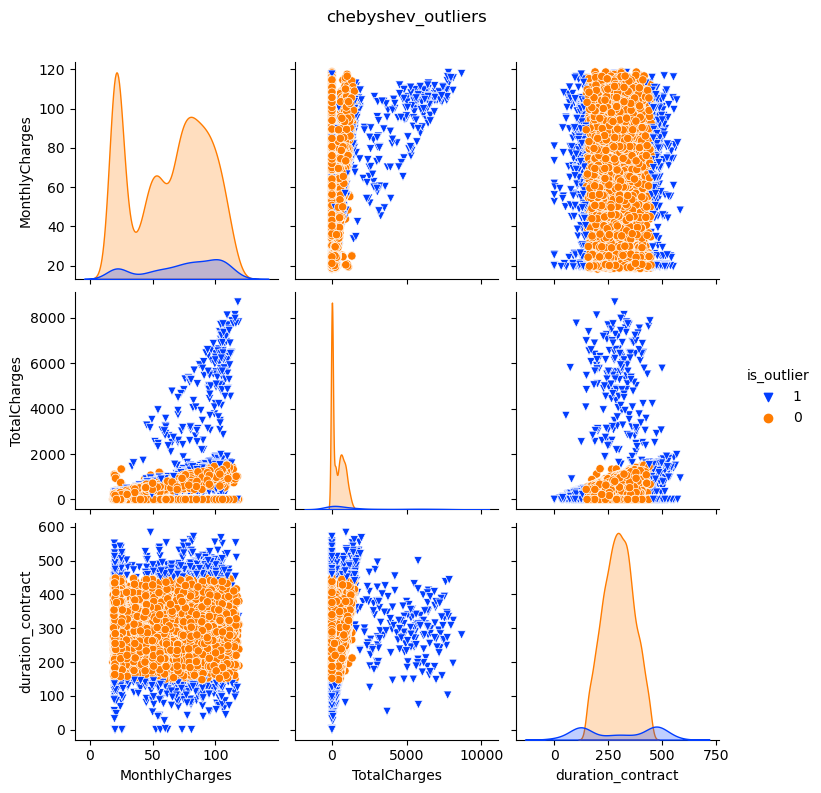

In [49]:
anomalies_report(chebyshev_outliers)
make_pairplot(labeled_data, 'chebyshev_outliers');

In [50]:
make_predict(LogisticRegression(), 'LR-chebyshev', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-chebyshev', 'ROC-AUC: 0.835, Accuracy: 0.77')

In [51]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-chebyshev', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-chebyshev', 'ROC-AUC: 0.783, Accuracy: 0.757')

In [52]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-chebyshev', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-chebyshev', 'ROC-AUC: 0.835, Accuracy: 0.773')

**Вывод:**
- Без улучшений, 

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**chebyshev_dist**|**LR** |**0.835**|**0.77**|
|        |**DTC**|**0.783**|**0.757** |
| ---    |**SC** |**0.835** |**0.773**|

- Относительно Евклидова и манхетонского тоже без улучшений

## DBSCAN
- Плотностной/вероятностный метод. Аномалии должны сильно отличаться от основных данных и скорее всего попадут в 'шум'
- eps: Максимальное расстояние между двумя образцами, при котором один считается соседним с другим.

In [53]:
cl = DBSCAN(eps=0.066, n_jobs=-1).fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in cl.labels_])

In [54]:
labeled_data = features.copy()
labeled_data['is_outlier'] = density_outlier

Total number of outliers: 1052
Percentage of outliers:   14.94%


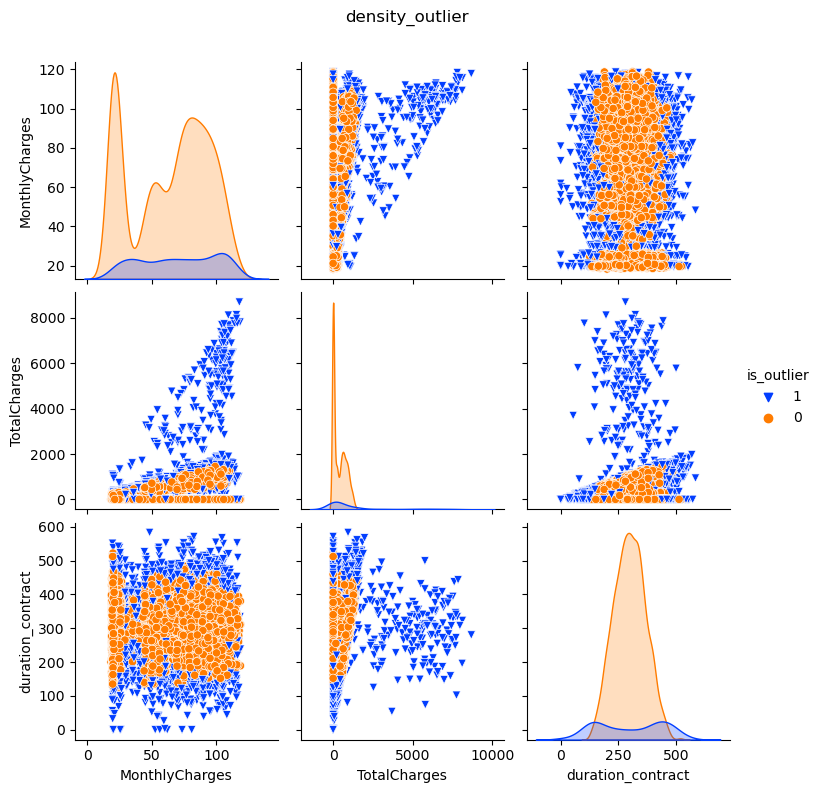

In [55]:
anomalies_report(density_outlier)
make_pairplot(labeled_data, 'density_outlier');

In [56]:
make_predict(LogisticRegression(), 'LR-DBSCAN', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-DBSCAN', 'ROC-AUC: 0.84, Accuracy: 0.773')

In [57]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-DBSCAN', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-DBSCAN', 'ROC-AUC: 0.783, Accuracy: 0.754')

In [58]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-DBSCAN', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-DBSCAN', 'ROC-AUC: 0.843, Accuracy: 0.776')

**Вывод:**
- Метод DBSCAN, без улучшений

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**DBSCAN**|**LR** |**0.84**|**0.773**|
|        |**DTC**|**0.783**|**0.754** |
|        |**SC** |**0.843** |**0.776**|

## One Class SVM
- Основная идея алгоритма (в случае с классификацией) - разделить классы гиперплоскостью так, чтобы максимизировать расстояние (зазор) между ними

In [59]:
one_class_svm = OneClassSVM(nu=0.1, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [60]:
labeled_data = features.copy()
labeled_data['is_outlier'] = svm_outliers

Total number of outliers: 703
Percentage of outliers:   9.98%


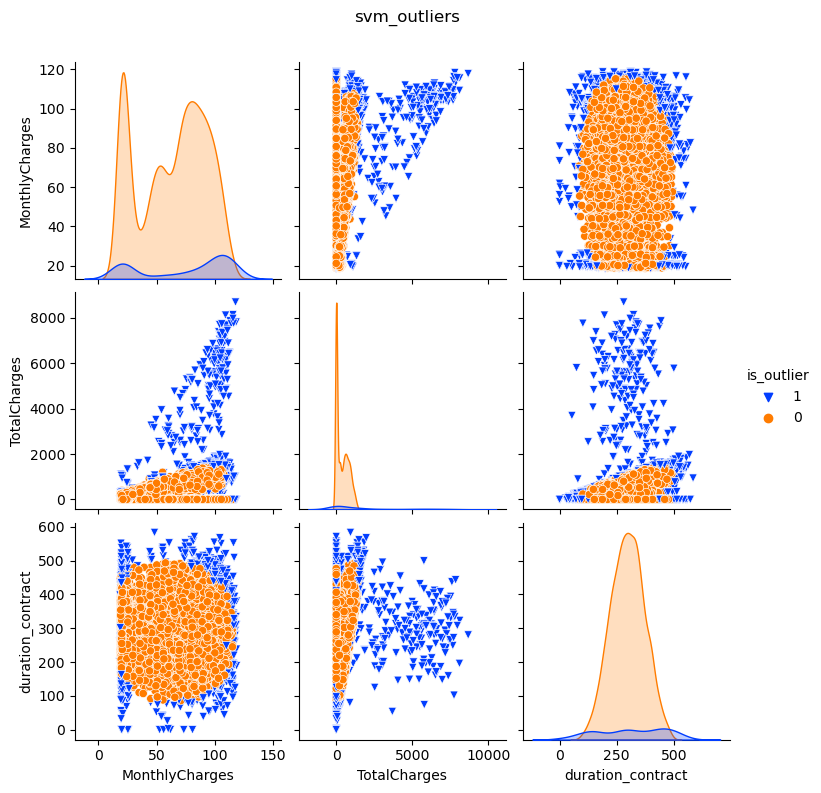

In [61]:
make_pairplot(labeled_data, 'svm_outliers');
anomalies_report(svm_outliers)

In [62]:
make_predict(LogisticRegression(), 'LR-SVM', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-SVM', 'ROC-AUC: 0.822, Accuracy: 0.759')

In [63]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'LR-SVM', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-SVM', 'ROC-AUC: 0.775, Accuracy: 0.751')

In [64]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-SVM', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-SVM', 'ROC-AUC: 0.822, Accuracy: 0.76')

**Вывод:**
- Метод One Class SVM, без улучшений

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**One Class SVM**|**LR** |**0.822**|**0.759**|
|        |**DTC**|**0.775**|**0.751** |
|        |**SC** |**0.822** |**0.76**|

# Isolation Forest
- Насколько легко можно "изолировать" наблюдение от всех остальных. Если слишком легко, наверное оно лежит далеко и является выбросом. Если очень тяжело - скорее всего она похожа на кучу других точек и выбросом не является.

In [65]:
isolation_forest = IsolationForest(n_estimators=300, contamination=0.1, #0.066
                                   max_features=2, bootstrap=True, n_jobs=-1, random_state=0)

isolation_forest.fit(scaled_data.values)
isolation_outliers = isolation_forest.predict(scaled_data.values)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [66]:
labeled_data = features.copy()
labeled_data['is_outlier'] = isolation_outliers

Total number of outliers: 705
Percentage of outliers:   10.01%


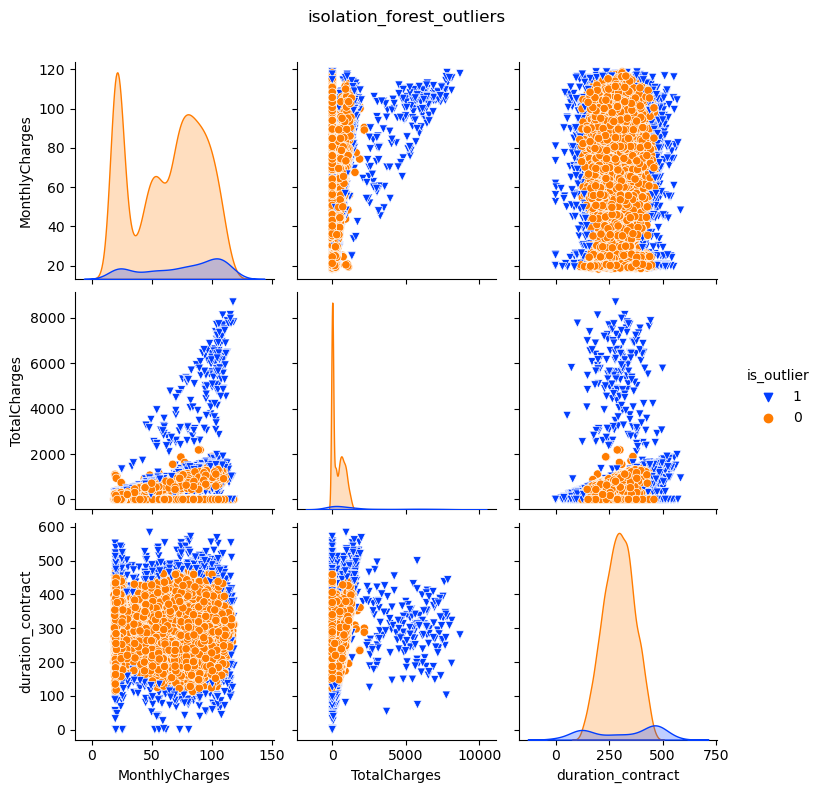

In [67]:
anomalies_report(isolation_outliers)
make_pairplot(labeled_data, 'isolation_forest_outliers');

In [68]:
make_predict(LogisticRegression(), 'LR-IsolationForest', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('LR-IsolationForest', 'ROC-AUC: 0.837, Accuracy: 0.774')

In [69]:
make_predict(DecisionTreeClassifier(random_state=111, max_depth=1, criterion='entropy'), 
             'DTC-IsolationForest', 5, labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('DTC-IsolationForest', 'ROC-AUC: 0.788, Accuracy: 0.759')

In [70]:
make_predict(SymbolicClassifier(parsimony_coefficient=.01,
                         random_state=1, n_jobs=-1), 'SC-IsolationForest', 5, 
                         labeled_data[labeled_data['is_outlier']!=1].iloc[:,:-1])

('SC-IsolationForest', 'ROC-AUC: 0.838, Accuracy: 0.777')

**Вывод:**
- Метод One Class SVM, без улучшений

|     |**BASE**|  |     |
|-----|-----|-----|-----|

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
| ----   |**LR** |**0.847**|**0.772** |
| ----   |**DTC**|**0.787**|**0.746** |
| ---    |**SC** |**0.851** |**0.754**|

***

| Method | Model | ROC-AUC | Accuracy |
| ------ | ------| ------- | -------- |
|**isolat_forest**|**LR** |**0.837**|**0.774**|
|        |**DTC**|**0.788**|**0.759** |
| ---    |**SC** |**0.838** |**0.777**|

***

# Общий вывод:
- Попробовали различные способы, при обработке выбросов
- Протестировали модели на 'сырых' данных и после обработки выбросов
- По итогам исследования получилась следующая таблица:

| Method | Model | ROC-AUC | Accuracy | 		
| ------ | ------| ------- | -------- |
| **3sigma**| **LR**|**0.838**|**0.769**|
| | **DTC**|**0.787**|**0.746**|
| | **SC**|**0.84**|**0.768**|
| **1.5IQR**| **LR**|**0.832**|**0.764**|
| | **DTC**|**0.785**|**0.748**|
| | **SC**|**0.837**|**0.766**|
| **euclidean_distance**| **LR**|**0.837**|**0.773**|
| | **DTC**|**0.781**|**0.756**|
| | **SC**|**0.835**|**0.771**|
| **cityblock_distance**| **LR**|**0.828**|**0.764**|
| | **DTC**|**0.781**|**0.753**|
| | **SC**|**0.83**|**0.767**|
| **chebyshev_distance**| **LR**|**0.835**|**0.77**|
| | **DTC**|**0.783**|**0.757**|
| | **SC**|**0.835**|**0.773**|
| **DBSCAN**| **LR**|**0.84**|**0.773**|	
| | **DTC**|**0.783**|**0.754**|
| | **SC**|**0.843**|**0.776**|
| **One Class SVM**| **LR**|**0.822**|**0.759**|
| | **DTC**|**0.775**|**0.751**|
| | **SC**|**0.822**|**0.76**|
| **Isolation Forest**| **LR**|**0.837**|**0.774**|	
| | **DTC**|**0.788**|**0.759**|
| | **SC**|**0.839**|**0.777**|

- Оценивали модели на кроссвалидации, на 5 фолдах
- Изучили различные подходы к обработке, статистические, основанные на расстояниях, основанные на плотностях/вероятностях, с помощью линейной модели, с помощью решающих деревьев, [генетического алгоритма](https://gplearn.readthedocs.io/en/stable/index.html)
- Лучший результат получился у SymbolicClassifier: ROC-AUC: 0.851, Accuracy: 0.754
- Используя различные подходы к обработке выбросов в этом случае не удалось улучшить целевые метрики